# Loop Combiner 

An unofficial impelmentation of:
Chen, B.-Y., Smith, J. B. L. and Yang, Y.-H. (2020) ‘Neural Loop Combiner: Neural Network Models for Assessing the Compatibility of Loops’. 

# Settings

In [1]:
import torchaudio
from pathlib import Path
import itertools
from matplotlib import pyplot as plt
import os

os.environ['CUDA_VISIBLE_DEVICES']='1, 2' # personal use

# CONSTANTS
SAMPLE_RATE = 44100

# Possible combinations of extracted tracks. 
TYPES_TRACK = ["drums.wav", "bass.wav", "other.wav"]
COMB_TRACK = list(itertools.combinations(TYPES_TRACK, 2))
print(COMB_TRACK)

[('drums.wav', 'bass.wav'), ('drums.wav', 'other.wav'), ('bass.wav', 'other.wav')]


# Dataset

In [2]:
import torchaudio
import torchvision
from torch.utils.data import Dataset
from pathlib import Path
import numpy as np 
import functools
import random
import torch
from torch.utils.data import DataLoader

class LoopComb_Triplet(Dataset):
    def __init__(self, path, size):
        dirs = list(Path(path).glob("*"))[:size]
        self.items = []

        dirnames = set(list(dirs))
        for d1 in dirs:
            d2 = random.choice(list(dirnames - set([d1])))
            for t1, t2 in COMB_TRACK:
                anchor = os.path.join(d1, t1)
                positive = os.path.join(d1, t2)
                negative = os.path.join(d2, t2)
                if (os.path.exists(anchor) and os.path.exists(positive) and os.path.exists(negative)):
                    self.items.append([anchor, positive, negative])
                
                anchor = os.path.join(d1, t2)
                positive = os.path.join(d1, t1)
                negative = os.path.join(d2, t1)
                if (os.path.exists(anchor) and os.path.exists(positive) and os.path.exists(negative)):
                    self.items.append([anchor, positive, negative])
                
        self.length = len(self.items)
        print("all samples #", len(self.items))
        self.transforms = torchvision.transforms.Compose(
            [torchaudio.transforms.MelSpectrogram(sample_rate = SAMPLE_RATE, n_fft=2048, hop_length=512, n_mels=128, normalized=False),
            torchaudio.transforms.AmplitudeToDB(top_db=80.)])

    @functools.lru_cache(maxsize=50000) # least recently used cache - 一番古く使われたものから消していく
    def __getitem__(self, index):
        (anchor_path, positive_path, negative_path) = self.items[index]
        anchor = self.convert_to_tensor(anchor_path)
        positive = self.convert_to_tensor(positive_path)
        negative = self.convert_to_tensor(negative_path)
        return anchor, positive, negative

    def __len__(self):
        return self.length

    def convert_to_tensor(self,filepath):
        audio_tensor, sr = torchaudio.load(filepath)
        audio_tensor = audio_tensor.mean(axis=0).unsqueeze(0)
        audio_tensor = torchaudio.transforms.Resample(orig_freq=sr, new_freq=SAMPLE_RATE)(audio_tensor)

        gain = random.uniform(0.75, 1.25) # data augumentation
        audio_tensor = torchaudio.transforms.Vol(gain=gain)(audio_tensor)

        return self.transforms(audio_tensor)

In [3]:
# datasets and dataloaders
train_path = './dataset/youtube-5m-loops-valid/train'
val_path = './dataset/youtube-5m-loops-valid/val'
trainSet = LoopComb_Triplet(train_path, -1)
valSet = LoopComb_Triplet(val_path,-1)

trainLoader = DataLoader(trainSet, batch_size=32, shuffle=True, num_workers=4)
valLoader = DataLoader(valSet, batch_size=32, shuffle=True, num_workers=4)

all samples # 39564
all samples # 3432


torch.Size([1, 128, 345])
tensor(37.4939) tensor(-42.5061) tensor(-32.2724) tensor(80.)


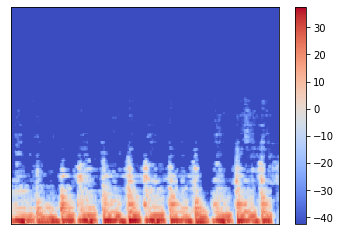

In [4]:
# Sample data
t1, t2, t3 = trainSet[random.randint(0, len(trainSet))]
print(t1.shape)

from librosa import display
plt.figure()
display.specshow(t1.detach().numpy()[0])
print(t1.max(), t1.min(), t1.mean(), t1.max()-t1.min())
plt.colorbar()

# Model

## TripletNet + Triplet Loss

In [12]:
import  torch
import  torch.nn    as  nn
import  torch.nn.functional as F

# GPU Settings
if torch.cuda.is_available():
    print("Using GPU")
    device = torch.device("cuda") 
else:
    print("Using CPU")
    device = torch.device("cpu")

class TripletNet(nn.Module):

    def __init__(self):
        super(TripletNet, self).__init__()
        dropout_rate = 0.1

        # Based on the model architecture described in the original paper
        # Chen, B.-Y., Smith, J. B. L. and Yang, Y.-H. (2020) ‘Neural Loop Combiner: Neural Network Models for Assessing the Compatibility of Loops’. 
        self.conv = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2),  # 64@96*96
            nn.PReLU(),
            # nn.Conv2d(32, 32, 3),  # 64@96*96
            # nn.ReLU(),
            nn.MaxPool2d(3),  # 64@48*48
            nn.Conv2d(16, 16, 3, stride=1),
            nn.PReLU(),    # 128@42*42
            nn.MaxPool2d(3),   # 128@21*21
#            nn.Conv2d(32, 4, 4),
#            nn.ReLU(), # 128@18*18
#            nn.MaxPool2d(2), # 128@9*9
#            nn.Conv2d(128, 256, 4),
#            nn.ReLU(),   # 256@6*6
        )
        self.fc = nn.Sequential(
            nn.Sequential(nn.Linear(1728, 1024), nn.PReLU()),
            nn.Sequential(nn.Linear(1024, 256), nn.PReLU()),
            nn.Sequential(nn.Linear(256, 4))
        )
        
    def forward_one(self, x):
        x = self.conv(x)
        x = x.view(x.size()[0], -1)
        x = self.fc(x)
        return x

    def forward(self, x1, x2, x3):
        out1 = self.forward_one(x1)
        out2 = self.forward_one(x2)
        out3 = self.forward_one(x3)
        return out1, out2, out3

Using GPU


In [6]:
class TripletLoss(nn.Module):
    """
    Triplet loss
    Takes embeddings of an anchor sample, a positive sample and a negative sample
    """

    def __init__(self, margin):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative, size_average=True):
        distance_positive = (anchor - positive).pow(2).sum(1)  # .pow(.5)
        distance_negative = (anchor - negative).pow(2).sum(1)  # .pow(.5)
        losses = F.relu(distance_positive - distance_negative + self.margin)
        return losses.mean() if size_average else losses.sum()

In [7]:
# Model Initialization

net = TripletNet()

margin = 5.0
loss_fn = TripletLoss(margin)
net.to(device)

TripletNet(
  (conv): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): PReLU(num_parameters=1)
    (2): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
    (4): PReLU(num_parameters=1)
    (5): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Sequential(
      (0): Linear(in_features=1728, out_features=1024, bias=True)
      (1): PReLU(num_parameters=1)
    )
    (1): Sequential(
      (0): Linear(in_features=1024, out_features=256, bias=True)
      (1): PReLU(num_parameters=1)
    )
    (2): Sequential(
      (0): Linear(in_features=256, out_features=4, bias=True)
    )
  )
)

In [8]:
for batch in valLoader:

    output1, output2, output3 = net(batch[0].to(device), batch[1].to(device), batch[2].to(device))
    loss = loss_fn(output1, output2, output3)
    
    print("loss", loss.data.item(), loss.item())
    break


/home/nao/anaconda3/envs/loopcomb/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


loss 5.016209602355957 5.016209602355957


In [9]:
# model summary
from torchsummary import summary

(t1, t2, t3) = trainSet[0]
summary(net.cuda(), [t1.shape, t2.shape, t3.shape])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 16, 63, 172]             160
             PReLU-2          [-1, 16, 63, 172]               1
         MaxPool2d-3           [-1, 16, 21, 57]               0
            Conv2d-4           [-1, 16, 19, 55]           2,320
             PReLU-5           [-1, 16, 19, 55]               1
         MaxPool2d-6            [-1, 16, 6, 18]               0
            Linear-7                 [-1, 1024]       1,770,496
             PReLU-8                 [-1, 1024]               1
            Linear-9                  [-1, 256]         262,400
            PReLU-10                  [-1, 256]               1
           Linear-11                    [-1, 4]           1,028
           Conv2d-12          [-1, 16, 63, 172]             160
            PReLU-13          [-1, 16, 63, 172]               1
        MaxPool2d-14           [-1, 16,

# Training

In [10]:
from torch.nn import Module
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

# Training loop
def train(model, optimizer, loss_fn, train_loader, val_loader, epochs=20, device="cpu"):
    best_val_loss = 10000.0

    for epoch in range(epochs):
        print("Epoch: ", epoch)
        training_loss = 0.0
        valid_loss, valid_acc = 0.0, 0.0

        model.train() # 学習モードにセット　DropoutLayerなどが有効に

        for batch in tqdm(train_loader):
            optimizer.zero_grad() # 一旦リセット

            output1, output2, output3 = model(batch[0].to(device), batch[1].to(device), batch[2].to(device))

            loss = loss_fn(output1, output2, output3)
            training_loss += loss.item()

            loss.backward() # back propagation - gradientの計算
            optimizer.step()
        training_loss /= len(train_loader) # average

        model.eval() # 学習モードをオフ　DropoutLayerなどが無効に モデルのパラメータはアップデートされない
        for batch in tqdm(val_loader):

            output1, output2, output3 = model(batch[0].to(device), batch[1].to(device), batch[2].to(device))

            loss = loss_fn(output1, output2, output3)
            valid_loss += loss.item()

        valid_loss /= len(val_loader)

        print('Epoch: {}, Training Loss: {:.2f}, Validation Loss: {:.2f}, Accuracy = {:.2f}'
            .format(epoch, training_loss, valid_loss, valid_acc))
        if valid_loss < best_val_loss:
            best_val_loss = valid_loss
            torch.save(net.state_dict(), "./tmp/model_triplet_epoch_%d_val_%.4f_acc_%.4f.pt" % (epoch, valid_loss, valid_acc))
            print("      saved in Epoch: {}".format(epoch))

In [11]:
net.train()

optimizer = torch.optim.Adam(net.parameters(),lr = 0.0001)
optimizer.zero_grad()

train(net, optimizer, loss_fn, trainLoader, valLoader, epochs=100, device=device)


Epoch:  0


100%|██████████| 108/108 [00:25<00:00,  4.24it/s]


Epoch: 0, Training Loss: 3.34, Validation Loss: 2.83, Accuracy = 0.00
      saved in Epoch: 0
Epoch:  1


100%|██████████| 108/108 [00:25<00:00,  4.21it/s]


Epoch: 1, Training Loss: 2.23, Validation Loss: 2.07, Accuracy = 0.00
      saved in Epoch: 1
Epoch:  2


100%|██████████| 108/108 [00:25<00:00,  4.20it/s]


Epoch: 2, Training Loss: 1.70, Validation Loss: 1.96, Accuracy = 0.00
      saved in Epoch: 2
Epoch:  3


100%|██████████| 108/108 [00:25<00:00,  4.27it/s]


Epoch: 3, Training Loss: 1.38, Validation Loss: 1.61, Accuracy = 0.00
      saved in Epoch: 3
Epoch:  4


100%|██████████| 108/108 [00:25<00:00,  4.23it/s]


Epoch: 4, Training Loss: 1.18, Validation Loss: 1.69, Accuracy = 0.00
Epoch:  5


100%|██████████| 108/108 [00:25<00:00,  4.27it/s]


Epoch: 5, Training Loss: 0.99, Validation Loss: 1.57, Accuracy = 0.00
      saved in Epoch: 5
Epoch:  6


100%|██████████| 108/108 [00:25<00:00,  4.27it/s]


Epoch: 6, Training Loss: 0.82, Validation Loss: 1.63, Accuracy = 0.00
Epoch:  7


100%|██████████| 108/108 [00:25<00:00,  4.22it/s]


Epoch: 7, Training Loss: 0.69, Validation Loss: 1.61, Accuracy = 0.00
Epoch:  8


100%|██████████| 108/108 [00:25<00:00,  4.22it/s]


Epoch: 8, Training Loss: 0.55, Validation Loss: 1.53, Accuracy = 0.00
      saved in Epoch: 8
Epoch:  9


100%|██████████| 108/108 [00:25<00:00,  4.23it/s]


Epoch: 9, Training Loss: 0.44, Validation Loss: 1.66, Accuracy = 0.00
Epoch:  10


100%|██████████| 108/108 [00:25<00:00,  4.25it/s]


Epoch: 10, Training Loss: 0.37, Validation Loss: 1.66, Accuracy = 0.00
Epoch:  11


100%|██████████| 108/108 [00:25<00:00,  4.24it/s]


Epoch: 11, Training Loss: 0.28, Validation Loss: 1.73, Accuracy = 0.00
Epoch:  12


100%|██████████| 108/108 [00:25<00:00,  4.25it/s]


Epoch: 12, Training Loss: 0.23, Validation Loss: 2.03, Accuracy = 0.00
Epoch:  13


100%|██████████| 108/108 [00:25<00:00,  4.20it/s]


Epoch: 13, Training Loss: 0.19, Validation Loss: 2.03, Accuracy = 0.00
Epoch:  14


100%|██████████| 108/108 [00:25<00:00,  4.22it/s]


Epoch: 14, Training Loss: 0.16, Validation Loss: 1.99, Accuracy = 0.00
Epoch:  15


100%|██████████| 108/108 [00:25<00:00,  4.20it/s]


Epoch: 15, Training Loss: 0.14, Validation Loss: 2.19, Accuracy = 0.00
Epoch:  16


100%|██████████| 108/108 [00:25<00:00,  4.22it/s]


Epoch: 16, Training Loss: 0.14, Validation Loss: 1.96, Accuracy = 0.00
Epoch:  17


100%|██████████| 108/108 [00:25<00:00,  4.22it/s]


Epoch: 17, Training Loss: 0.09, Validation Loss: 2.60, Accuracy = 0.00
Epoch:  18


100%|██████████| 108/108 [00:25<00:00,  4.22it/s]


Epoch: 18, Training Loss: 0.11, Validation Loss: 2.52, Accuracy = 0.00
Epoch:  19


100%|██████████| 108/108 [00:25<00:00,  4.22it/s]


Epoch: 19, Training Loss: 0.09, Validation Loss: 2.50, Accuracy = 0.00
Epoch:  20


100%|██████████| 108/108 [00:25<00:00,  4.20it/s]


Epoch: 20, Training Loss: 0.10, Validation Loss: 2.54, Accuracy = 0.00
Epoch:  21


100%|██████████| 108/108 [00:25<00:00,  4.21it/s]


Epoch: 21, Training Loss: 0.09, Validation Loss: 2.57, Accuracy = 0.00
Epoch:  22


100%|██████████| 108/108 [00:25<00:00,  4.22it/s]


Epoch: 22, Training Loss: 0.09, Validation Loss: 2.89, Accuracy = 0.00
Epoch:  23


100%|██████████| 108/108 [00:25<00:00,  4.24it/s]


Epoch: 23, Training Loss: 0.09, Validation Loss: 2.40, Accuracy = 0.00
Epoch:  24


100%|██████████| 108/108 [00:25<00:00,  4.21it/s]


Epoch: 24, Training Loss: 0.07, Validation Loss: 2.70, Accuracy = 0.00
Epoch:  25


100%|██████████| 108/108 [00:25<00:00,  4.22it/s]


Epoch: 25, Training Loss: 0.06, Validation Loss: 2.42, Accuracy = 0.00
Epoch:  26


100%|██████████| 108/108 [00:25<00:00,  4.22it/s]


Epoch: 26, Training Loss: 0.08, Validation Loss: 2.53, Accuracy = 0.00
Epoch:  27


100%|██████████| 108/108 [00:25<00:00,  4.26it/s]


Epoch: 27, Training Loss: 0.06, Validation Loss: 2.69, Accuracy = 0.00
Epoch:  28


100%|██████████| 108/108 [00:25<00:00,  4.23it/s]


Epoch: 28, Training Loss: 0.06, Validation Loss: 2.59, Accuracy = 0.00
Epoch:  29


100%|██████████| 108/108 [00:25<00:00,  4.23it/s]


Epoch: 29, Training Loss: 0.07, Validation Loss: 2.69, Accuracy = 0.00
Epoch:  30


100%|██████████| 108/108 [00:25<00:00,  4.28it/s]


Epoch: 30, Training Loss: 0.05, Validation Loss: 2.97, Accuracy = 0.00
Epoch:  31


100%|██████████| 108/108 [00:25<00:00,  4.25it/s]


Epoch: 31, Training Loss: 0.07, Validation Loss: 2.40, Accuracy = 0.00
Epoch:  32


100%|██████████| 108/108 [00:25<00:00,  4.24it/s]


Epoch: 32, Training Loss: 0.06, Validation Loss: 2.76, Accuracy = 0.00
Epoch:  33


 75%|███████▌  | 928/1237 [03:37<01:12,  4.27it/s]


KeyboardInterrupt: 



# Test

In [ ]:
torch.save(net.state_dict(), './tmp/weigtht.pt')

In [ ]:
import IPython.display
IPython.display.Audio("sample.wav")

path1, path2 = random.choice(valSet.positives)




In [ ]:
from torchsummary import summary

(t1, t2), label = trainSet[0]

print(t1.shape)

summary(net.cuda(), [(1, 128, 173),(1, 128, 173)])

#net.forward(t1, t2)
#print(t1.mean(axis=0).shape)
net.cuda().forward(t1.unsqueeze(0).cuda(), t2.unsqueeze(0).cuda())

In [ ]:
#torch.cuda.empty_cache()

In [ ]:
a = torch.ones((1), device='cuda', requires_grad=False)
print(a.detach().item())
# na = a.detach().to('cpu').numpy()
# na[0][0]=10
# print(a)